In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np

from scipy.stats import spearmanr, kendalltau

from einops import rearrange

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
ckpt = "/data/scratch/twhit/checkpoints/trained_encoder_dc2_redbin3.ckpt"

with initialize(config_path="../../", version_base=None):
    cfg = compose("config_dc2_redbin3", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Configure the test dataloader:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

Load in encoder weights:

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

Store true and posterior mode shear and convergence for the test images:

In [5]:
shear1_true = torch.zeros(len(test_dl), 8, 8, 3, device=device)
shear1_pred = torch.zeros(len(test_dl), 8, 8, 3, device=device)
shear1_baseline = torch.zeros(len(test_dl), 8, 8, 3, device=device)
shear2_true = torch.zeros(len(test_dl), 8, 8, 3, device=device)
shear2_pred = torch.zeros(len(test_dl), 8, 8, 3, device=device)
shear2_baseline = torch.zeros(len(test_dl), 8, 8, 3, device=device)
convergence_true = torch.zeros(len(test_dl), 8, 8, 3, device=device)
convergence_pred = torch.zeros(len(test_dl), 8, 8, 3, device=device)
ra = torch.zeros(len(test_dl), 8, 8, 3, device=device)
dec = torch.zeros(len(test_dl), 8, 8, 3, device=device)
test_loss = torch.zeros(len(test_dl), device = device)

i = -1
for b in test_dl:
    i += 1
    batch = move_data_to_device(b, device)
    
    shear1_true[i] = batch['tile_catalog']['shear_1'].squeeze().flip(dims=[0,1])
    shear2_true[i] = batch['tile_catalog']['shear_2'].squeeze().flip(dims=[0,1])
    convergence_true[i] = batch['tile_catalog']['convergence'].squeeze().flip(dims=[0,1])
    ra[i] = batch['tile_catalog']['ra'].squeeze().flip(dims=[0,1])
    dec[i] = batch['tile_catalog']['dec'].squeeze().flip(dims=[0,1])
    
    with torch.no_grad():
        mode_cat = encoder.sample(batch, use_mode=True)
        test_loss[i] = encoder._compute_loss(batch, None)
    
    shear1_pred[i] = mode_cat['shear_1'].squeeze().flip(dims=[0,1])
    shear1_baseline[i] = batch['tile_catalog']['ellip_lsst_wavg'][...,0].squeeze().flip(dims=[0,1])
    shear2_pred[i] = mode_cat['shear_2'].squeeze().flip(dims=[0,1])
    shear2_baseline[i] = batch['tile_catalog']['ellip_lsst_wavg'][...,1].squeeze().flip(dims=[0,1])
    convergence_pred[i] = mode_cat['convergence'].squeeze().flip(dims=[0,1])

/home/twhit/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Compute test MSEs:

In [6]:
for b in range(3):
    print(f'redshift bin {b}')
    print(f'shear 1 test MSE (BLISS) = {((shear1_true[...,b] - shear1_pred[...,b]) ** 2).mean()}')
    print(f'shear 2 test MSE (BLISS) = {((shear2_true[...,b] - shear2_pred[...,b]) ** 2).mean()}')
    print(f'convergence test MSE = {((convergence_true[...,b] - convergence_pred[...,b]) ** 2).mean()}\n')

redshift bin 0
shear 1 test MSE (BLISS) = 9.980959475797135e-06
shear 2 test MSE (BLISS) = 1.4156740689941216e-05
convergence test MSE = 1.7543414287501946e-05

redshift bin 1
shear 1 test MSE (BLISS) = 6.190512067405507e-05
shear 2 test MSE (BLISS) = 6.419477722374722e-05
convergence test MSE = 8.392900781473145e-05

redshift bin 2
shear 1 test MSE (BLISS) = 0.00020204587781336159
shear 2 test MSE (BLISS) = 0.00020694515842478722
convergence test MSE = 0.000206926473765634



Compute Pearson correlation coefficients:

In [7]:
for b in range(3):
    print(f'redshift bin {b}')
    print(f'shear 1 pearson correlation (BLISS) = {np.corrcoef(shear1_true[...,b].flatten().cpu(), shear1_pred[...,b].flatten().cpu())[1,0]}')
    print(f'shear 2 pearson correlation (BLISS) = {np.corrcoef(shear2_true[...,b].flatten().cpu(), shear2_pred[...,b].flatten().cpu())[1,0]}')
    print(f'convergence pearson correlation = {np.corrcoef(convergence_true[...,b].flatten().cpu(), convergence_pred[...,b].flatten().cpu())[1,0]}\n')

redshift bin 0
shear 1 pearson correlation (BLISS) = 0.287703528906601
shear 2 pearson correlation (BLISS) = 0.3235763874149146
convergence pearson correlation = 0.5573737413679586

redshift bin 1
shear 1 pearson correlation (BLISS) = 0.4249706412440683
shear 2 pearson correlation (BLISS) = 0.44367299927694037
convergence pearson correlation = 0.7473559067893393

redshift bin 2
shear 1 pearson correlation (BLISS) = 0.43135782227075853
shear 2 pearson correlation (BLISS) = 0.40487489893252104
convergence pearson correlation = 0.7762224123622509



Compute Spearman correlation coefficients:

In [8]:
for b in range(3):
    print(f'redshift bin {b}')
    print(f'shear 1 spearman correlation (BLISS) = {spearmanr(shear1_true[...,b].flatten().cpu(), shear1_pred[...,b].flatten().cpu())[0]}')
    print(f'shear 2 spearman correlation (BLISS) = {spearmanr(shear2_true[...,b].flatten().cpu(), shear2_pred[...,b].flatten().cpu())[0]}')
    print(f'convergence spearman correlation = {spearmanr(convergence_true[...,b].flatten().cpu(), convergence_pred[...,b].flatten().cpu())[0]}\n')

redshift bin 0
shear 1 spearman correlation (BLISS) = 0.2766107851493312
shear 2 spearman correlation (BLISS) = 0.24246969329221713
convergence spearman correlation = 0.3709284487181672

redshift bin 1
shear 1 spearman correlation (BLISS) = 0.4209941104560364
shear 2 spearman correlation (BLISS) = 0.38748438774182187
convergence spearman correlation = 0.7271162049747425

redshift bin 2
shear 1 spearman correlation (BLISS) = 0.4146472250476
shear 2 spearman correlation (BLISS) = 0.35282088549961993
convergence spearman correlation = 0.7379173568314128



Compute Kendall correlation coefficients:

In [9]:
for b in range(3):
    print(f'redshift bin {b}')
    print(f'shear 1 kendall correlation (BLISS) = {kendalltau(shear1_true[...,b].flatten().cpu(), shear1_pred[...,b].flatten().cpu())[0]}')
    print(f'shear 2 kendall correlation (BLISS) = {kendalltau(shear2_true[...,b].flatten().cpu(), shear2_pred[...,b].flatten().cpu())[0]}')
    print(f'convergence kendall correlation = {kendalltau(convergence_true[...,b].flatten().cpu(), convergence_pred[...,b].flatten().cpu())[0]}\n')

redshift bin 0
shear 1 kendall correlation (BLISS) = 0.1891938016361715
shear 2 kendall correlation (BLISS) = 0.16643230084297797
convergence kendall correlation = 0.25224670468303106

redshift bin 1
shear 1 kendall correlation (BLISS) = 0.29149666800611324
shear 2 kendall correlation (BLISS) = 0.27156777516843034
convergence kendall correlation = 0.5377136474729679

redshift bin 2
shear 1 kendall correlation (BLISS) = 0.28618775557105625
shear 2 kendall correlation (BLISS) = 0.2440620860388956
convergence kendall correlation = 0.5489424040805108



Compute test loss:

In [10]:
print(f'test loss = {test_loss.mean()}')

test loss = -31.450422286987305


Scatterplots of true vs. posterior mode shear and convergence:

In [11]:
alpha = 0.25
s = 20
fontsize = 24
ticklabelsize = 16
bliss_color = 'darkorchid'
baseline_color = 'sienna'
axmin = -0.06
axmax = 0.06

Redshift bin 0:

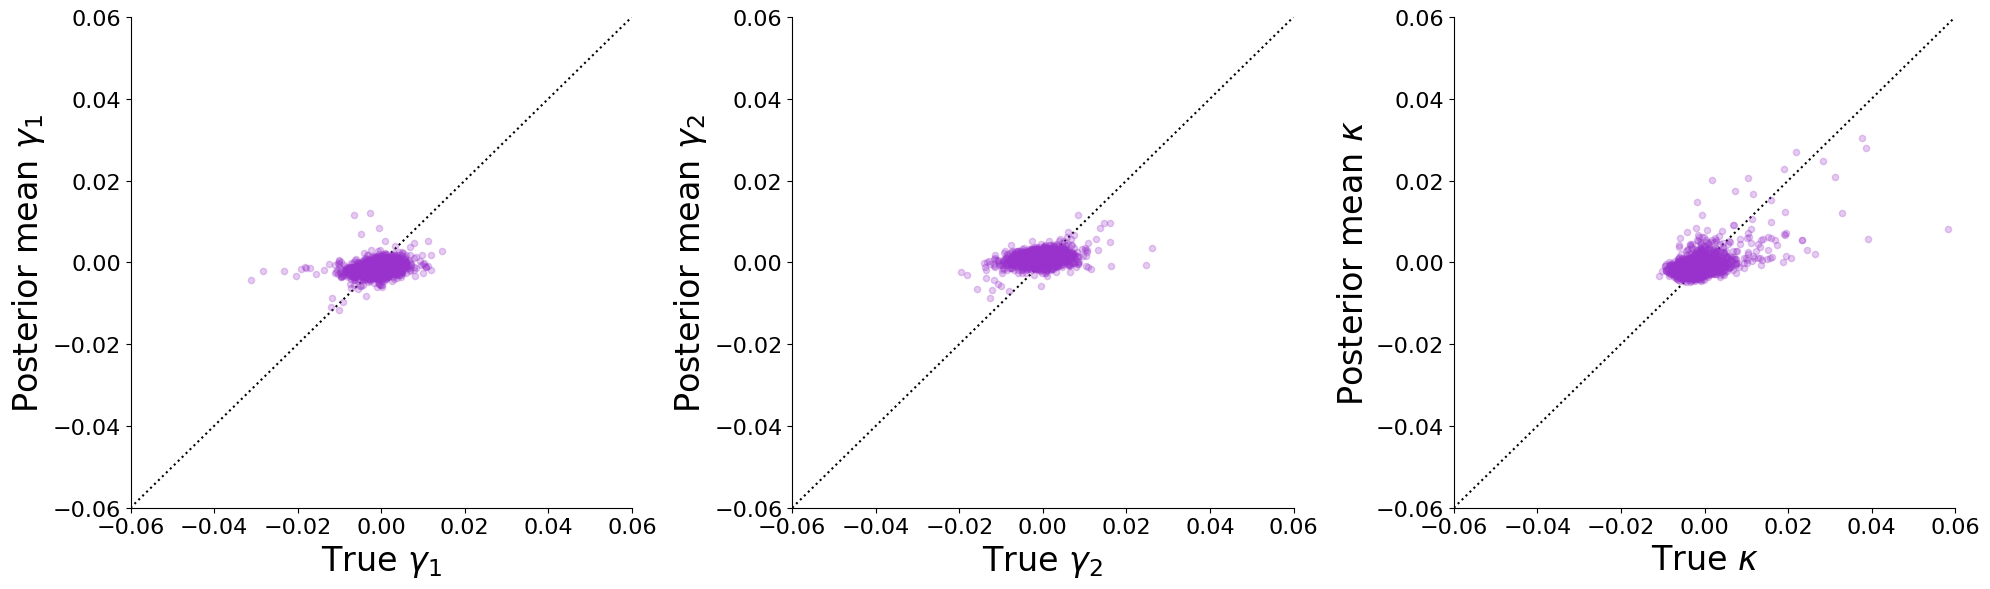

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
b = 0

_ = ax[0].scatter(shear1_true[...,b].flatten().cpu(), shear1_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[0].set_ylabel(r'Posterior mean $\gamma_1$', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[1].scatter(shear2_true[...,b].flatten().cpu(), shear2_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1].set_ylabel(r'Posterior mean $\gamma_2$', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[2].scatter(convergence_true[...,b].flatten().cpu(), convergence_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[2].set_xlabel(r'True $\kappa$', fontsize = fontsize)
_ = ax[2].set_ylabel(r'Posterior mean $\kappa$', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/scatterplots_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 1:

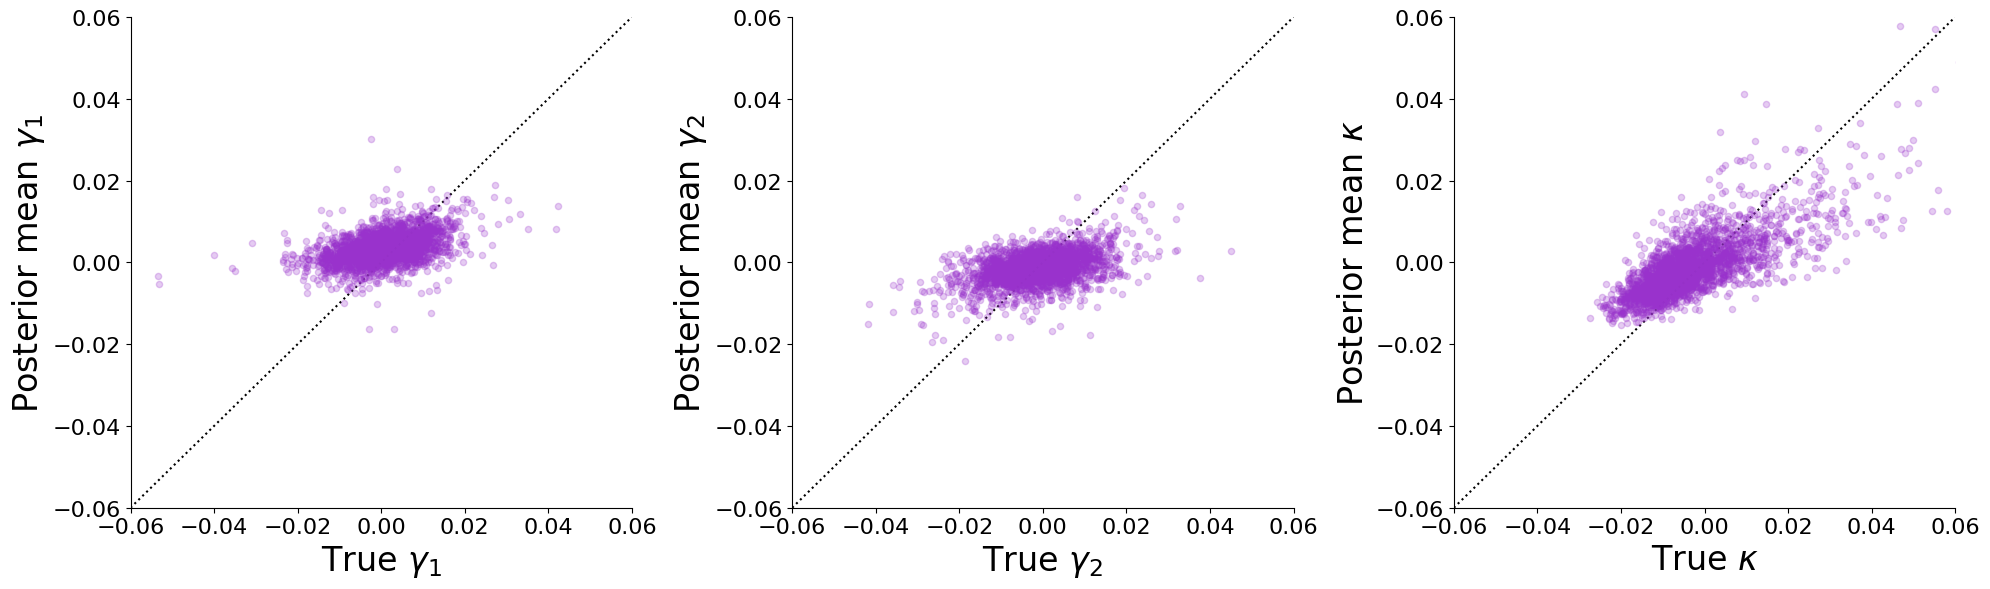

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
b = 1

_ = ax[0].scatter(shear1_true[...,b].flatten().cpu(), shear1_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[0].set_ylabel(r'Posterior mean $\gamma_1$', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[1].scatter(shear2_true[...,b].flatten().cpu(), shear2_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1].set_ylabel(r'Posterior mean $\gamma_2$', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[2].scatter(convergence_true[...,b].flatten().cpu(), convergence_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[2].set_xlabel(r'True $\kappa$', fontsize = fontsize)
_ = ax[2].set_ylabel(r'Posterior mean $\kappa$', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/scatterplots_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Redshift bin 2:

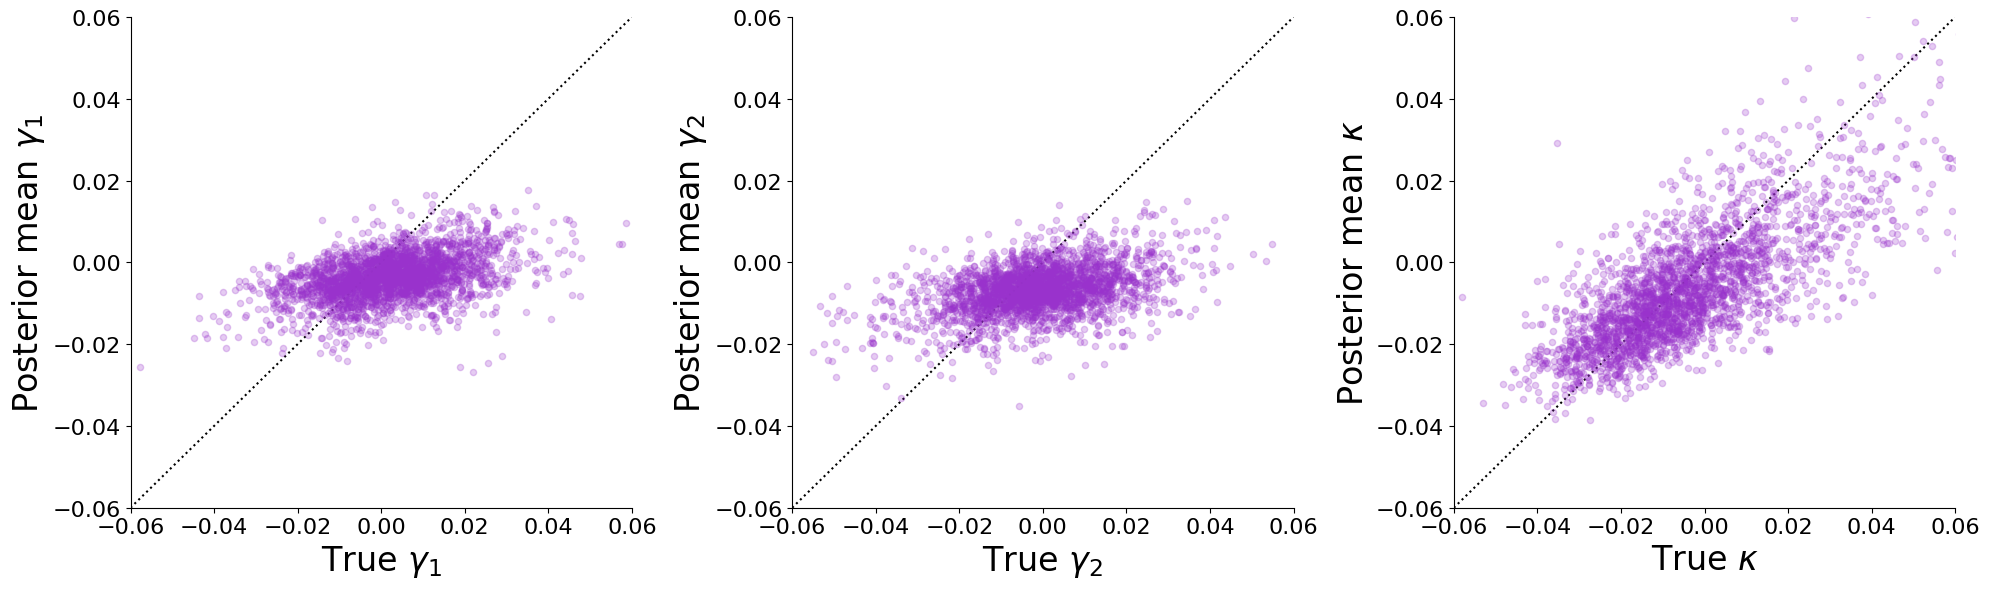

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
b = 2

_ = ax[0].scatter(shear1_true[...,b].flatten().cpu(), shear1_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[0].set_xlabel(r'True $\gamma_1$', fontsize = fontsize)
_ = ax[0].set_ylabel(r'Posterior mean $\gamma_1$', fontsize = fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))
_ = ax[0].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[1].scatter(shear2_true[...,b].flatten().cpu(), shear2_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[1].set_xlabel(r'True $\gamma_2$', fontsize = fontsize)
_ = ax[1].set_ylabel(r'Posterior mean $\gamma_2$', fontsize = fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))
_ = ax[1].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

_ = ax[2].scatter(convergence_true[...,b].flatten().cpu(), convergence_pred[...,b].flatten().cpu(),
                  color = bliss_color, alpha = alpha, s = s, zorder = 1)
_ = ax[2].set_xlabel(r'True $\kappa$', fontsize = fontsize)
_ = ax[2].set_ylabel(r'Posterior mean $\kappa$', fontsize = fontsize)
_ = ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[2].set_xlim((axmin, axmax))
_ = ax[2].set_ylim((axmin, axmax))
_ = ax[2].axline((0,0), slope = 1, linestyle = ':', color = 'black', zorder = 0)

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()

fig.savefig(f"figures/scatterplots_bin{b}.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

Posterior mean shear and convergence maps for the entire test set:

In [15]:
mask = (dec[...,0] > -36.4).all([-1,-2])
ra_subset = ra[mask]
dec_subset = dec[mask]
shear1_true_subset = shear1_true[mask]
shear1_pred_subset = shear1_pred[mask]
shear2_true_subset = shear2_true[mask]
shear2_pred_subset = shear2_pred[mask]
convergence_true_subset = convergence_true[mask]
convergence_pred_subset = convergence_pred[mask]

In [16]:
ra_mean = ra_subset[...,0].mean([-1,-2])
dec_mean = dec_subset[...,0].mean([-1,-2])
radec_mean = torch.stack((ra_mean, dec_mean), dim=-1)
sorted_indices = torch.argsort(- radec_mean[:,1] * 1e5 + radec_mean[:,0])

In [17]:
ra_subset_sorted = rearrange(ra_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
dec_subset_sorted = rearrange(dec_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear1_true_subset_sorted = rearrange(shear1_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear1_pred_subset_sorted = rearrange(shear1_pred_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear2_true_subset_sorted = rearrange(shear2_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
shear2_pred_subset_sorted = rearrange(shear2_pred_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
convergence_true_subset_sorted = rearrange(convergence_true_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")
convergence_pred_subset_sorted = rearrange(convergence_pred_subset[sorted_indices].view(6,4,8,8,3), "h w nh nw b -> (h nh) (w nw) b")

In [18]:
vmin = -0.06
vmax = 0.06
fontsize = 24
ticklabelsize = 16
interpolation = 'none'

extent = [ra_subset_sorted.min().cpu(), ra_subset_sorted.max().cpu(),
          dec_subset_sorted.min().cpu(), dec_subset_sorted.max().cpu()]

/tmp/ipykernel_1992404/2818792044.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  _ = fig.tight_layout()


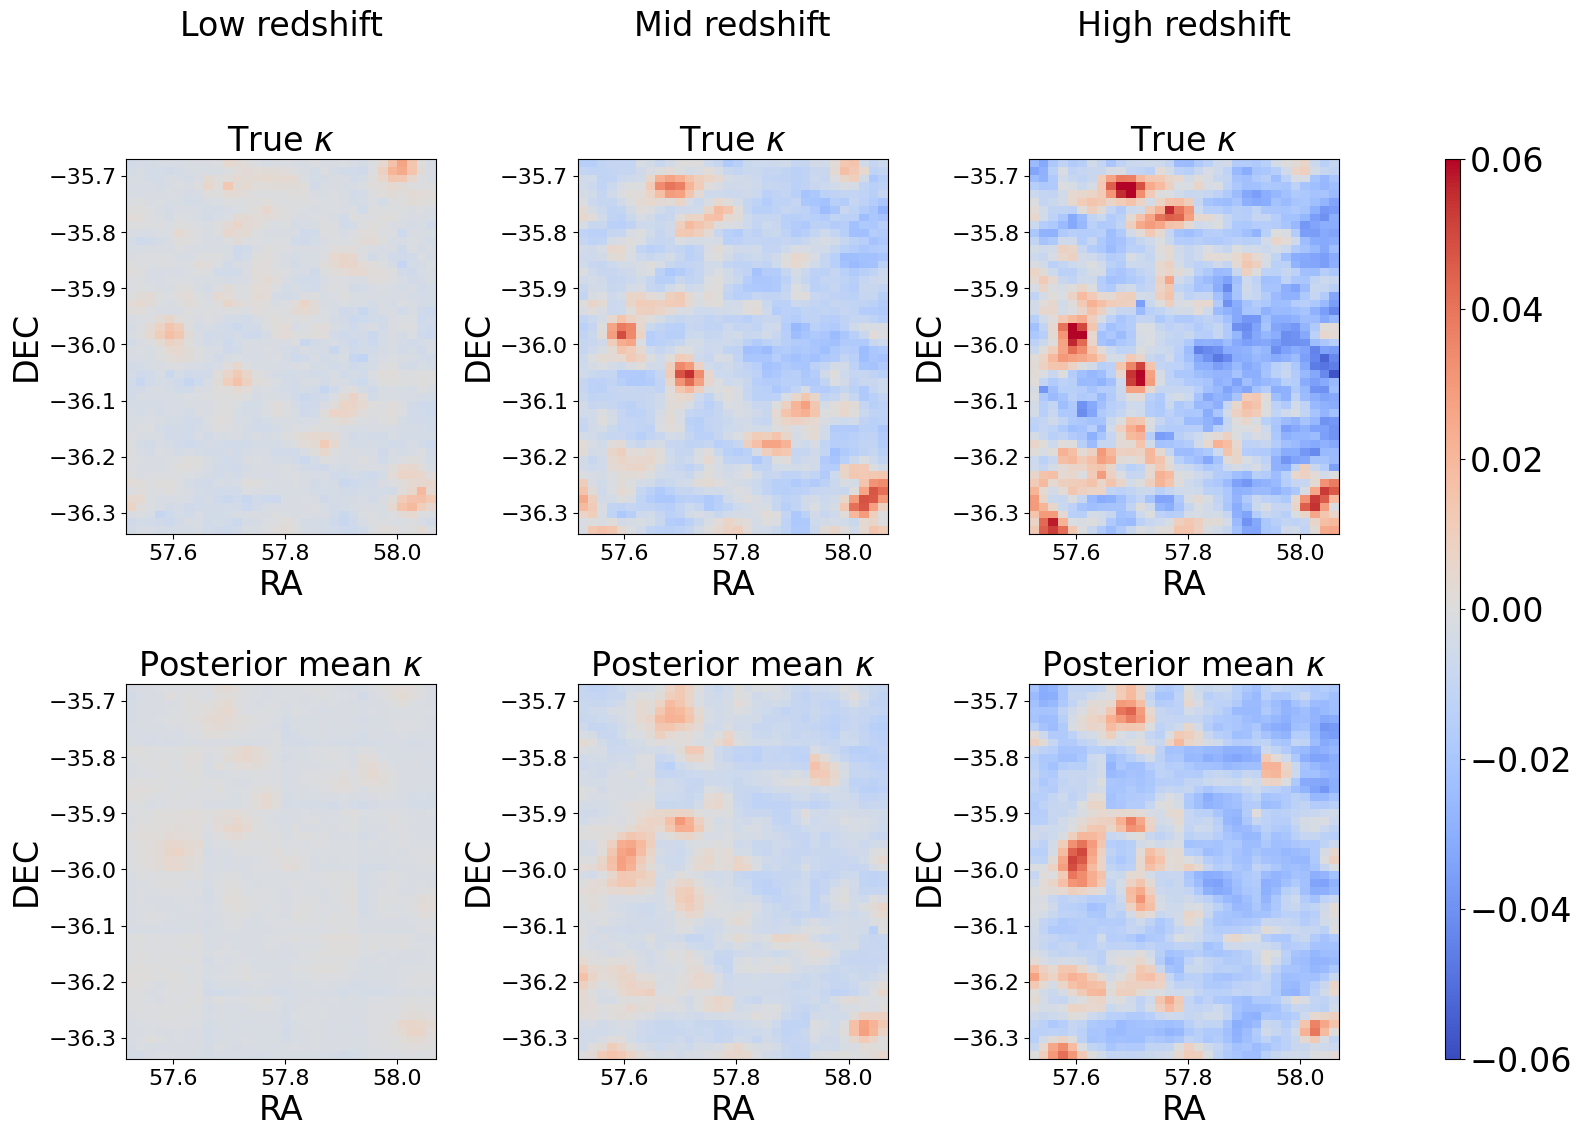

In [19]:
fig, ax = plt.subplots(2, 3, figsize = (15,10))

_ = ax[0,0].imshow(convergence_true_subset_sorted[...,0].cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[0,0].set_title('Low redshift\n\n\nTrue $\kappa$', fontsize = fontsize)
_ = ax[1,0].imshow(convergence_pred_subset_sorted[...,0].cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[1,0].set_title('Posterior mean $\kappa$', fontsize = fontsize)

_ = ax[0,1].imshow(convergence_true_subset_sorted[...,1].cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[0,1].set_title('Mid redshift\n\n\nTrue $\kappa$', fontsize = fontsize)
_ = ax[1,1].imshow(convergence_pred_subset_sorted[...,1].cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[1,1].set_title('Posterior mean $\kappa$', fontsize = fontsize)

_ = ax[0,2].imshow(convergence_true_subset_sorted[...,2].cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[0,2].set_title('High redshift\n\n\nTrue $\kappa$', fontsize = fontsize)
conv = ax[1,2].imshow(convergence_pred_subset_sorted[...,2].cpu(), extent = extent,
                   interpolation = interpolation, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
_ = ax[1,2].set_title('Posterior mean $\kappa$', fontsize = fontsize)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.05, 0.01, 0.9])
cbar_ax.tick_params(labelsize = fontsize)
fig.colorbar(conv, cax=cbar_ax)

_ = fig.tight_layout()

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.01, hspace=0.4)

for a in ax.flat:
    a.tick_params(axis='both', which='major', labelsize=ticklabelsize)
    a.set_xlabel('RA', fontsize = fontsize)
    a.set_ylabel('DEC', fontsize = fontsize)


# Bin 0 only
for i in range(2):
    for j in [1, 2]:
        ax[i, j].set_visible(False)
fig.savefig(f"figures/posteriormeanconvergencemaps_bin0.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

# Bins 0 and 1
for a in ax.flat:
    a.set_visible(True)
for i in range(2):
    ax[i, 2].set_visible(False)
fig.savefig(f"figures/posteriormeanconvergencemaps_bin1.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

# Bins 0, 1, and 2
for a in ax.flat:
    a.set_visible(True)
fig.savefig(f"figures/posteriormeanconvergencemaps_bin2.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)